
# Compute and evaluate worker efficiency for individual harvest day


Starts from the trained model, performs test run followed by computation and evaluation of worker efficiency.

In [147]:
# Parameters
root_dir = "/home/uddhav/WorkerActivityRecognitionEfficiencyEstimation"
dataset_dir = "./datasets/SantaMaria"
cart_data_dir = dataset_dir + "/cart_data"

# (date_time, model_path) = ("4-24-24", "./weights/mass_imu_0210-1540.keras")
# (date_time, model_path) = ("5-4-24", "./weights/mass_imu_0210-1618.keras")
# (date_time, model_path) = ("5-11-24", "./weights/mass_imu_0210-1657.keras")
# (date_time, model_path) = ("5-15-24", "./weights/mass_imu_0210-1450.keras")
(date_time, model_path) = ("5-25-24", "./weights/mass_imu_0121-2135.keras")


In [ ]:
#general imports
import warnings
warnings.filterwarnings("ignore")
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
from sklearn.preprocessing import RobustScaler


sys.path.append("./utils")
import dataFiltering as data_filter 
from yieldnn2025 import YieldNN  
from utils.misc import compute_datetime
from utils.misc import calculate_durations
from utils.misc import replace_largest_breaks_with_median


plt.rcParams['figure.figsize'] = [20, 10]
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'
tf.get_logger().setLevel('ERROR')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
csv_path=os.path.join(cart_data_dir,date_time+"_train-ready_all_carts.csv")
cart_data=pd.read_csv(
    csv_path,
    on_bad_lines="error",
    encoding="ISO-8859-1",
)

In [150]:
raw_field_data = {}
unique_cart_ids = cart_data['date_cartID'].str.split('_').str[1].unique()

for cart_id in unique_cart_ids:
    raw_field_data[cart_id] = cart_data[cart_data['date_cartID']==date_time+'_'+cart_id].to_numpy()

print("Cart IDs:", raw_field_data.keys())


Cart IDs: dict_keys(['Cart1', 'Cart11', 'Cart13', 'Cart16', 'Cart2', 'Cart20', 'Cart24', 'Cart32', 'Cart38', 'Cart4', 'Cart60', 'Cart61', 'Cart62', 'Cart63', 'Cart69', 'Cart70', 'Cart73', 'Cart74', 'Cart75', 'Cart77', 'Cart8'])


In [151]:
filtered_data_cnn={}

for cart_id in raw_field_data.keys():

    cart_data=raw_field_data[cart_id]
    X_test=data_filter.prepare_test(cart_data)
    y_pred=data_filter.run_model(X_test,model_path)
    y_pred1 = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], 1, y_pred.shape[2])
    y_pred1 = np.repeat(y_pred1, 100, axis=2).reshape(y_pred.shape[0], y_pred.shape[1] * 100, y_pred.shape[2])
    y_pred1 = y_pred1.reshape(-1, 2)[:,1] #0 NoPick 1 Pick
    y_pred1 = np.where(y_pred1 >= 0.5, "Pick", "NoPick").astype(str)
    cart_data = np.column_stack((cart_data, y_pred1[:len(cart_data)]))
    non_string_columns = cart_data[:, 1:-2].astype(float)  # Exclude string columns (first and last)
    cart_data = cart_data[~np.isnan(non_string_columns).any(axis=1)]
    filtered_data_cnn[cart_id]=cart_data

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Text(0.5, 1.0, 'CNN filtered data')

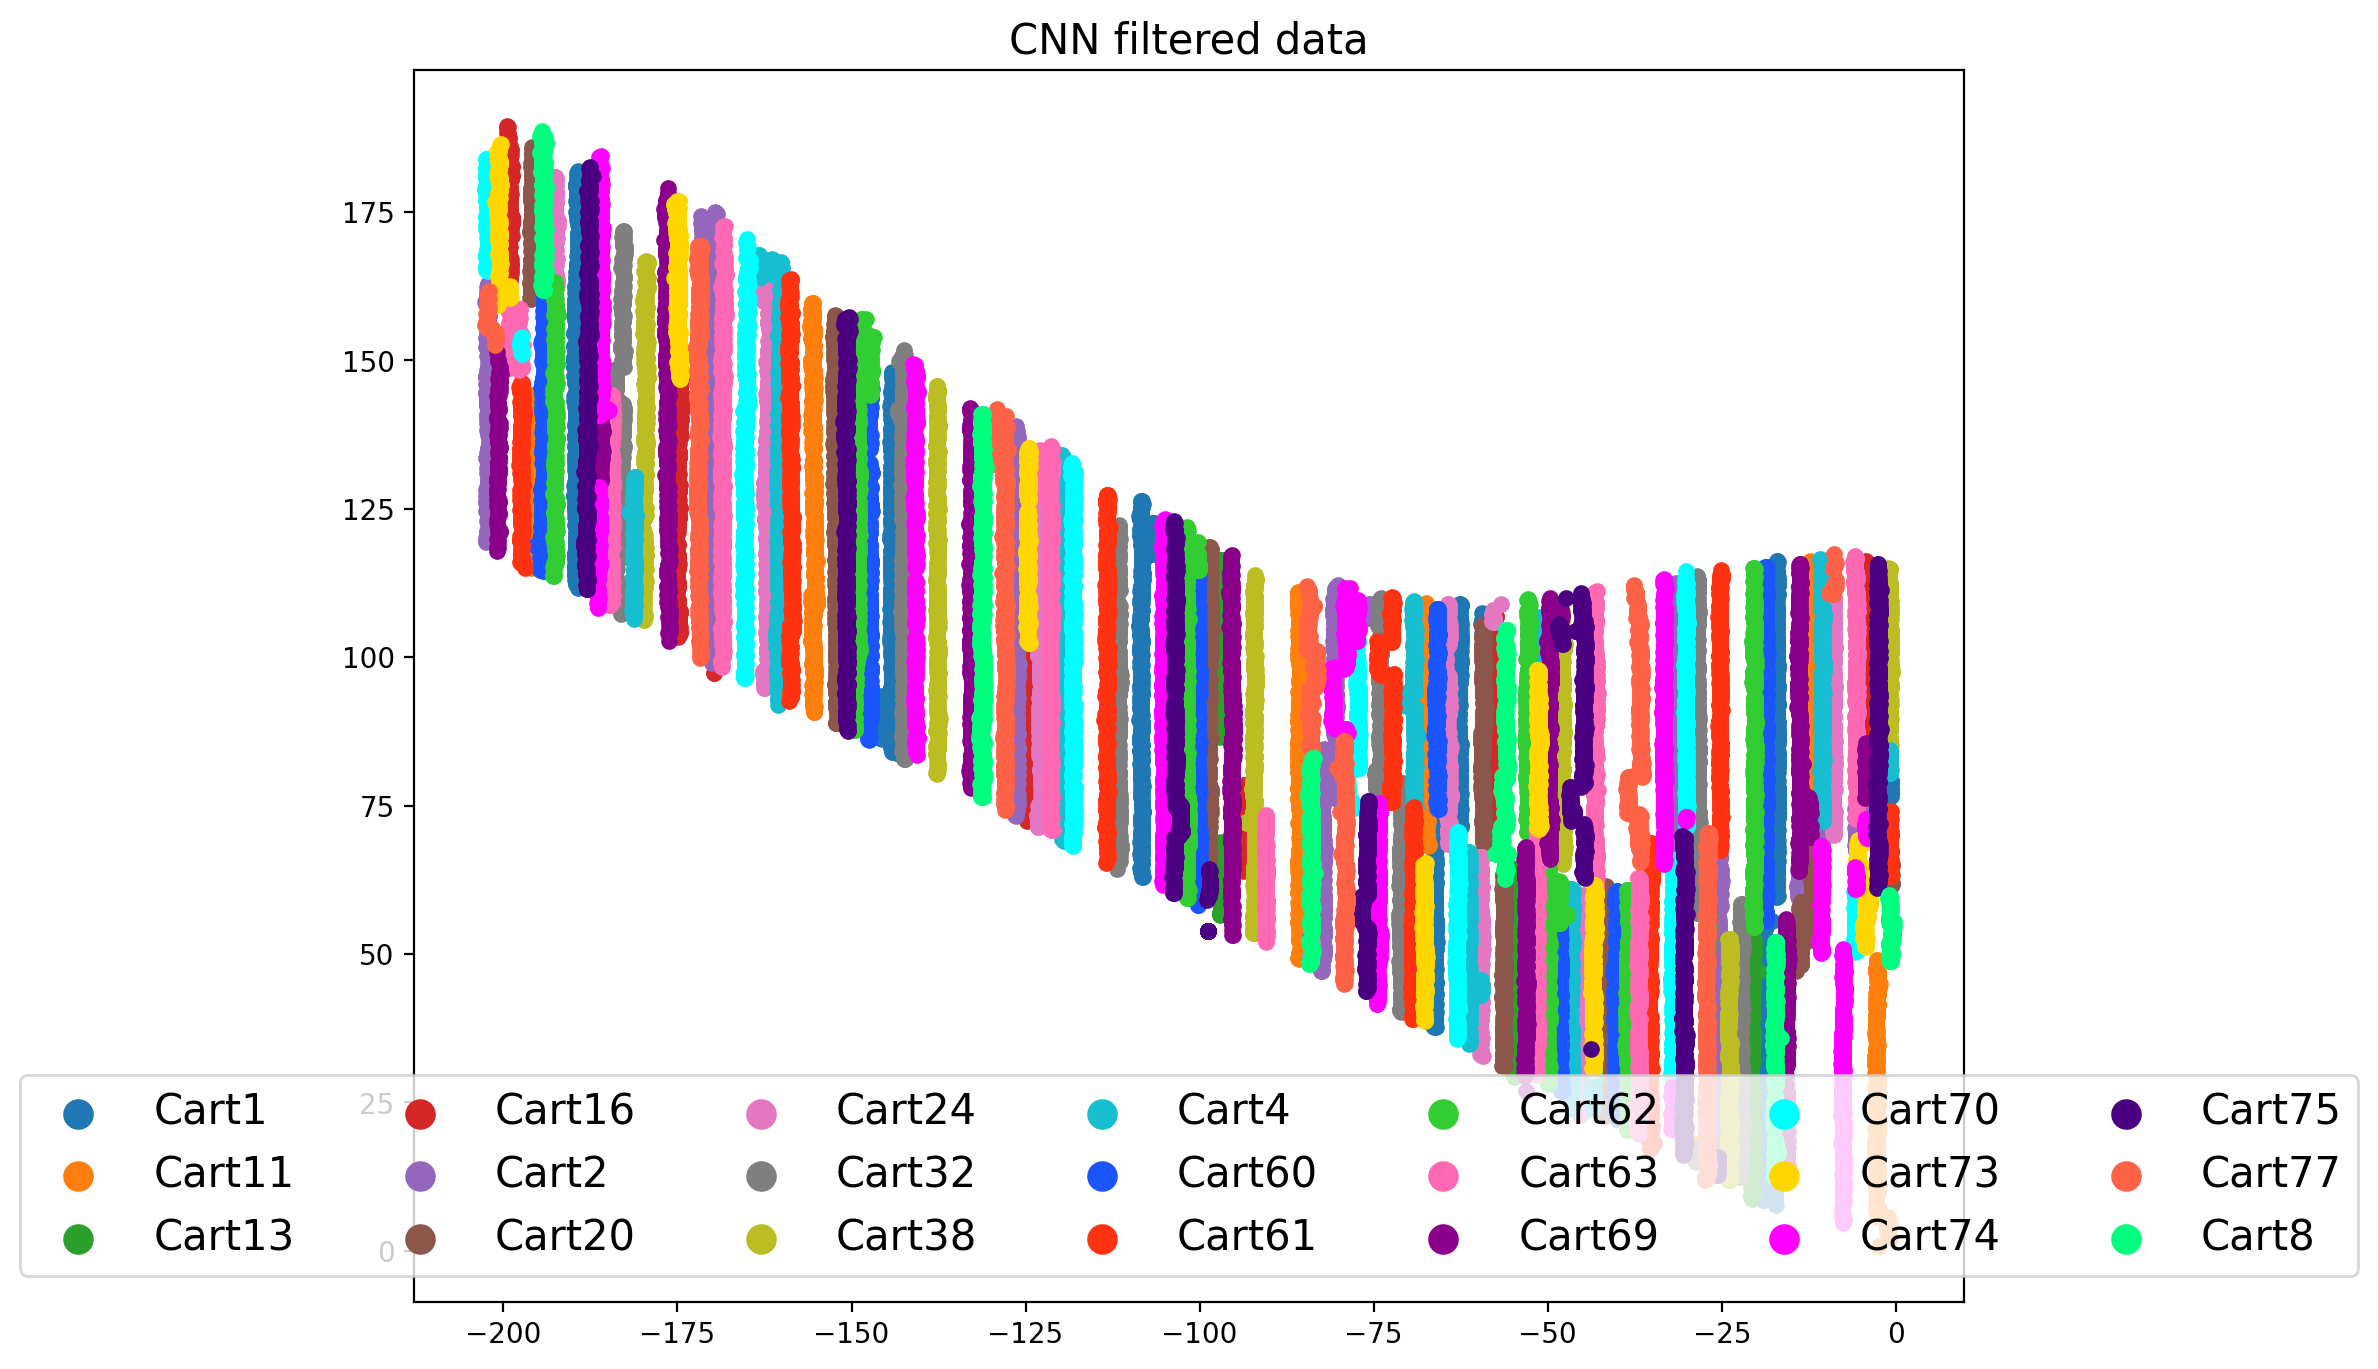

In [152]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#1a55FF', '#ff3311', '#32CD32', '#FF69B4', '#8B008B',
          '#00FFFF', '#FFD700', '#FF00FF', '#4B0082', '#FF6347',
          '#00FF7F', '#DC143C', '#00CED1', '#FF4500', '#DA70D6',
          '#32CD32', '#FF69B4', '#87CEEB', '#DDA0DD', '#F0E68C']
plt.figure(figsize=(10, 8))
index=0
dn=50
for cart in filtered_data_cnn.keys():
    N = len(filtered_data_cnn[cart])
    cart_data= filtered_data_cnn[cart]
    cart_data_filtered = cart_data[cart_data[:, -1] == "Pick"]
    plt.scatter(cart_data_filtered[0:N:dn, 2], cart_data_filtered[0:N:dn, 3], s=25, c=colors[index%len(colors)], label=cart)
    index=index+1
plt.legend(fontsize=15, loc='lower center', bbox_to_anchor=(0.5, 0.004), ncol=len(filtered_data_cnn.keys())//3,markerscale=2)

plt.title("CNN filtered data",fontsize=15)

In [153]:
# map_path="./field_maps/SantaMaria2024.txt"

# map_data = data_filter.load_map(map_path)
# odom_NDs = map_data['odom_NDs']
# odom_FDs = map_data['odom_FDs']
# utm_NDs = map_data['utm_NDs']
# utm_FDs = map_data['utm_FDs']
# llh_NDs = map_data['llh_NDs'] 
# llh_FDs = map_data['llh_FDs']
# odom_T_utm = map_data['odom_T_utm']

In [154]:

# picking_area = data_filter.get_pick_area_santamaria_24(odom_NDs, odom_FDs, tolerance_x=1, tolerance_y=0)
# filtered_data_picking=data_filter.identify_range_outliers(filtered_data_cnn,picking_area)


In [155]:
# for cart_id in filtered_data_picking.keys():
#     print("Before after length cart_id", cart_id, ":", len(filtered_data_cnn[cart_id]), len(filtered_data_picking[cart_id]))

In [156]:
# plt.figure(figsize=(10, 8))
# index=0
# dn=50
# for cart in filtered_data_picking.keys():
#     N = len(filtered_data_picking[cart])
#     cart_data= filtered_data_picking[cart]
#     cart_data_filtered = cart_data[cart_data[:, -1] == "Pick"]
#     plt.scatter(cart_data_filtered[0:N:dn, 2], cart_data_filtered[0:N:dn, 3], s=25, c=colors[index%len(colors)], label=cart)
#     index=index+1
# plt.legend(fontsize=15, loc='lower center', bbox_to_anchor=(0.5, 0.004), ncol=len(filtered_data_picking.keys())//3,markerscale=2)

# plt.title("CNN and boundary filtered data",fontsize=15)

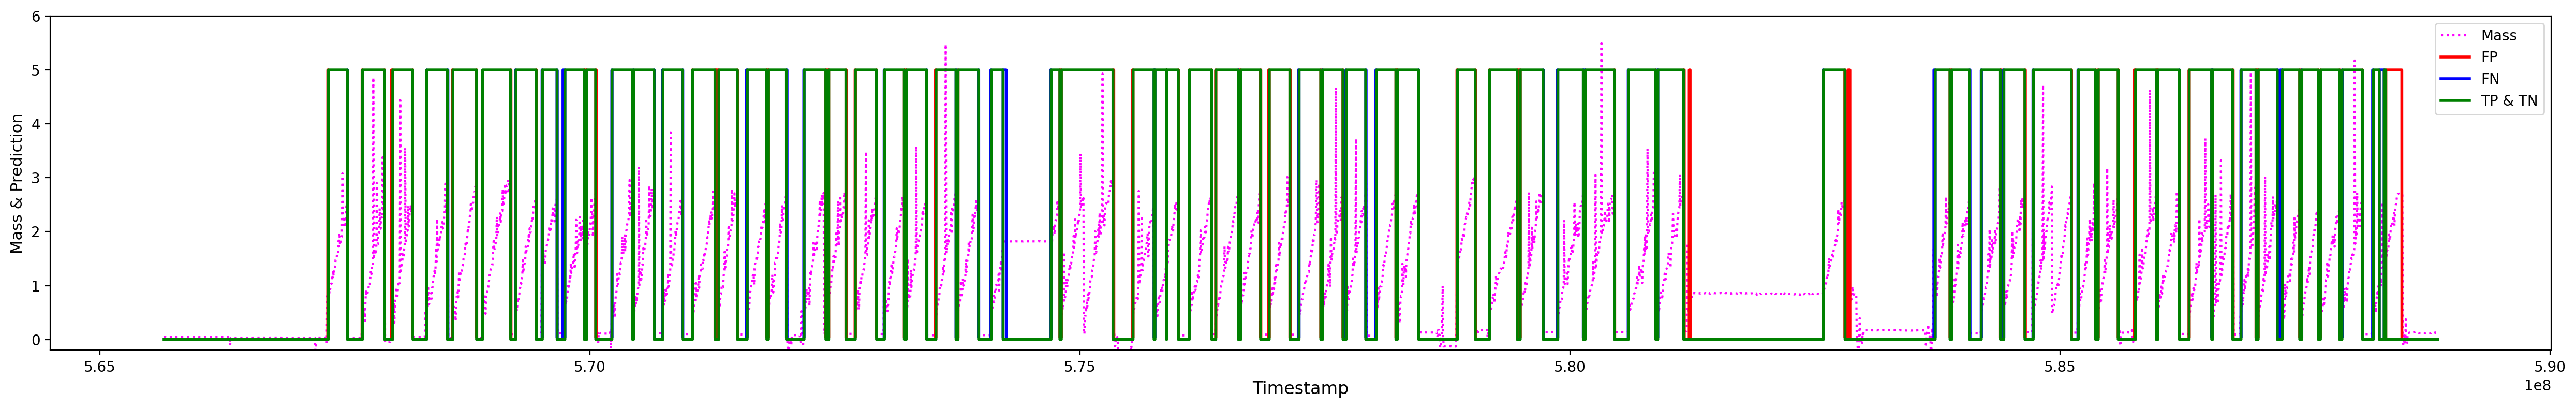

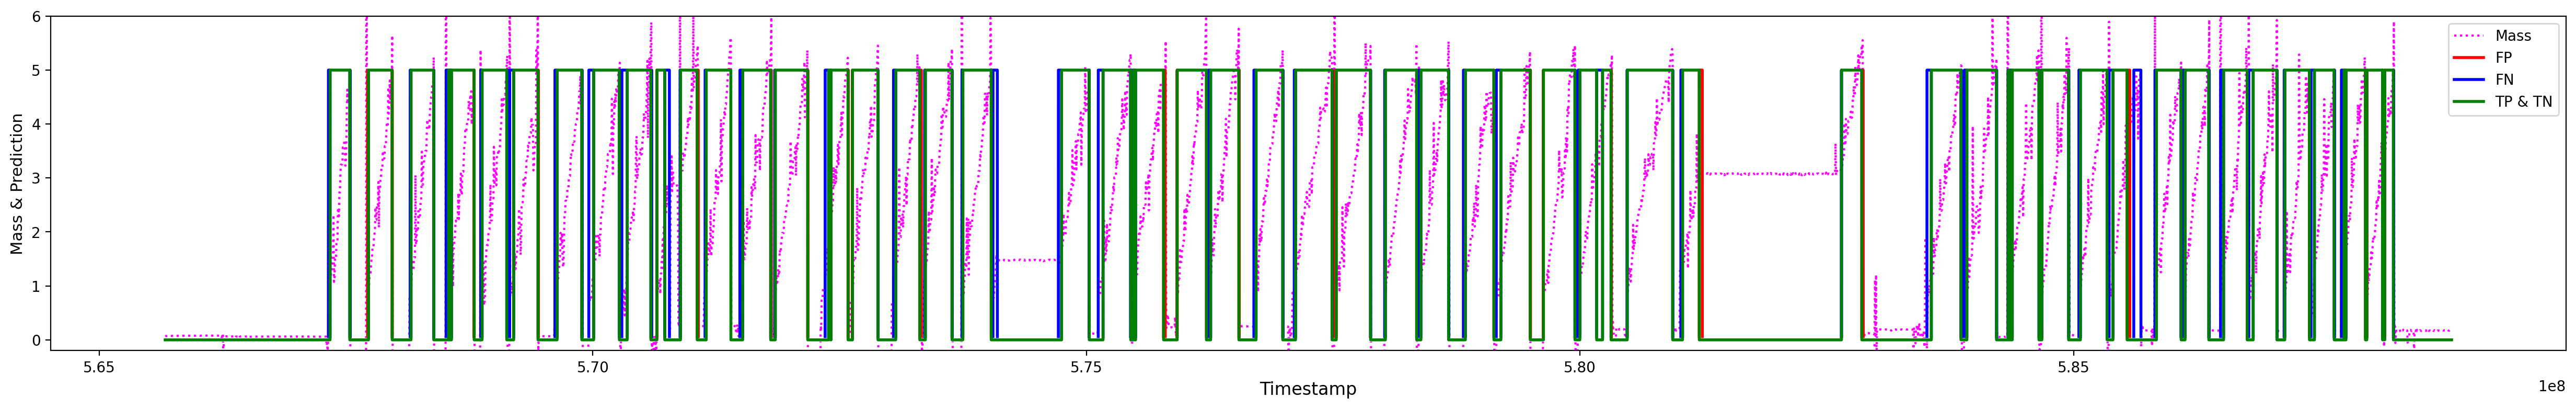

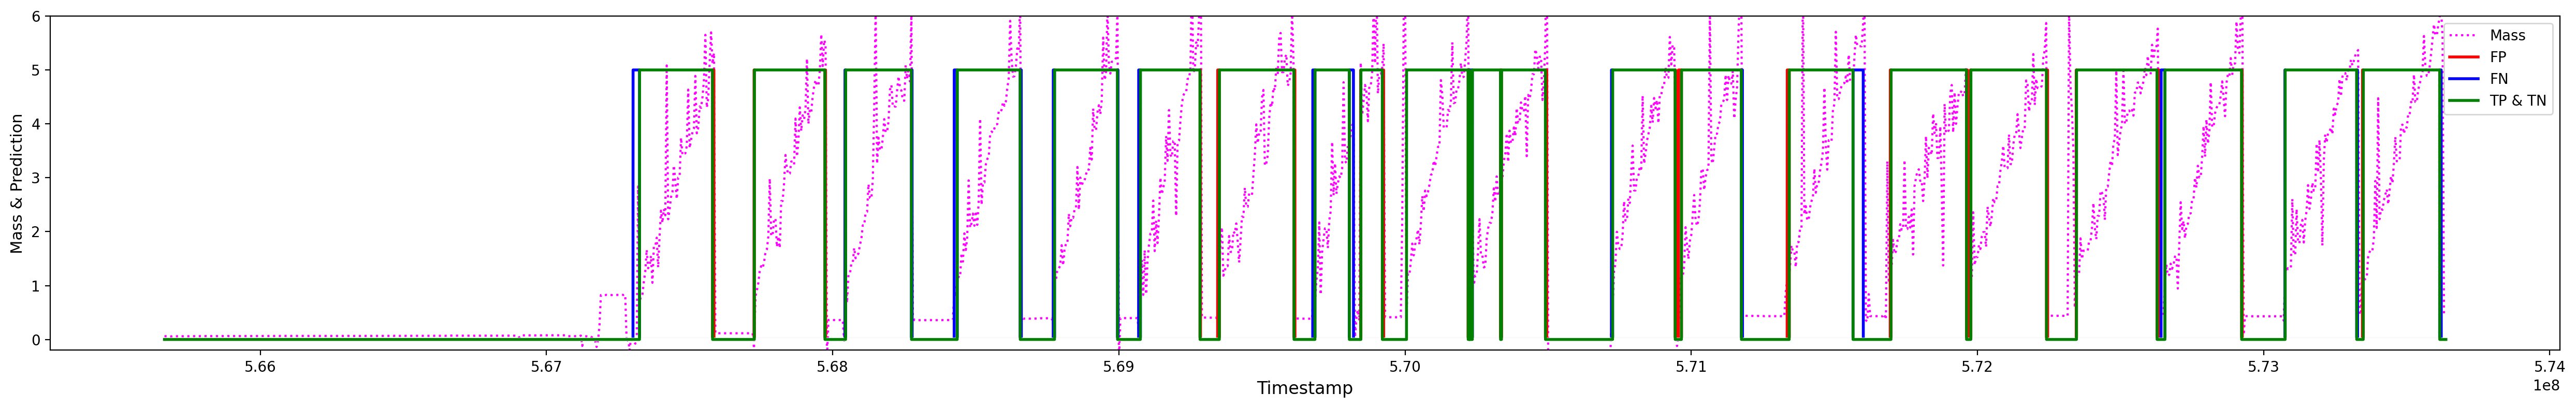

In [157]:
# ['stamps','lat','lon','filter_mass','imu_mass','raw_mass','ax','ay','az','flag','east','north','x','y']
filtered_data_picking=filtered_data_cnn
carts= list(filtered_data_picking.keys())[0:3]  # Select first 3 carts for plotting
# carts=["Cart73"]
for sample_cart in carts:
    cart_data_pred=filtered_data_picking[sample_cart]
    y_gt = cart_data_pred[:, -2]  # Assuming the last column is the ground truth
    y_gt=np.where(y_gt == 'Pick', 1, 0).astype(int)  # Convert to binary values: 1 for 'Pick', 0 for 'NoPick'
    
    y_pred=cart_data_pred[:, -1]
    y_pred=np.where(y_pred == 'Pick', 1, 0).astype(int)  # Convert to binary values: 1 for 'Pick', 0 for 'NoPick'

    mult_factor=5
    div_factor=1
    
    # Ensure boolean masks are correctly shaped
    tp = (y_gt == 1) & (y_pred == 1)  # True Positives (Green)
    tn = (y_gt == 0) & (y_pred == 0)

    fp = (y_gt == 0) & (y_pred == 1) & (tp==0) & (tn==0) # False Positives (Red)
    fn = (y_gt == 1) & (y_pred == 0)  # False Negatives (Magenta)
    
    # X-axis
    x = cart_data_pred[:, 1]

    plt.figure(figsize=(25,4))
    
    
    plt.plot(cart_data_pred[0:-1:dn, 1], cart_data_pred[0:-1:dn,7] / div_factor,linestyle=":",c='magenta',label="Mass")
    plt.plot(x, fp*mult_factor, color='red', linestyle='-', linewidth=2, label='FP')
    plt.plot(x, fn*mult_factor, color='blue', linestyle='-', linewidth=2, label='FN')
    plt.plot(x, np.zeros_like(x), color='white', linestyle='-', linewidth=2.5)
    plt.plot(x, tp*mult_factor, color='green', linestyle='-', linewidth=2, label='TP & TN')



    plt.xlabel("Timestamp", fontsize=12)
    plt.ylabel("Mass & Prediction", fontsize=11)

    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)

    
    plt.tight_layout()
    plt.legend(loc='upper right')

    plt.ylim((-0.2,6))

    plt.show()
    


In [158]:
# class_gt_pred header should be [date_time, stamps]
class_gt_pred={
    'harvest_date':[],
    'cart_id':[],
    'stamps':[],
    'raw_mass':[],
    'pick_status':[],
    'pred_status':[]

}
for cart in filtered_data_picking:
    cart_data=filtered_data_picking[cart]
    cart_no=int(cart[4:])
    y_gt= cart_data[:, -2]  # Assuming the second last column is the ground truth
    y_gt=np.where(y_gt == 'Pick', 1, 0).astype(int)  # Convert to binary values: 1 for 'Pick', 0 for 'NoPick'
    y_pred=cart_data[:, -1]
    y_pred=np.where(y_pred == 'Pick', 1, 0).astype(int)  # Convert to binary values: 1 for 'Pick', 0 for 'NoPick'

    class_gt_pred['harvest_date'].extend([date_time]*len(cart_data))
    class_gt_pred['cart_id'].extend([cart_no]*len(cart_data))
    class_gt_pred['raw_mass'].extend(cart_data[:, 7])  # Assuming raw_mass is the 5th column
    class_gt_pred['stamps'].extend(cart_data[:,1])
    class_gt_pred['pick_status'].extend(y_gt)
    class_gt_pred['pred_status'].extend(y_pred)
    # plt.figure(figsize=(10, 8))
    


In [159]:
class_gt_pred=pd.DataFrame(class_gt_pred)
class_gt_pred.head(10)

,harvest_date,cart_id,stamps,raw_mass,pick_status,pred_status
0,5-25-24,1,565657200,0.043662,0,0
1,5-25-24,1,565657300,0.043414,0,0
2,5-25-24,1,565657400,0.043121,0,0
3,5-25-24,1,565657500,0.043422,0,0
4,5-25-24,1,565657600,0.043422,0,0
5,5-25-24,1,565657700,0.043751,0,0
6,5-25-24,1,565657800,0.043954,0,0
7,5-25-24,1,565657900,0.043954,0,0
8,5-25-24,1,565658000,0.043939,0,0
9,5-25-24,1,565658100,0.043865,0,0


In [160]:
class_gt_pred['datetime_pacific'] = class_gt_pred.apply(compute_datetime, axis=1)
class_gt_pred.head()



,harvest_date,cart_id,stamps,raw_mass,pick_status,pred_status,datetime_pacific
0,5-25-24,1,565657200,0.043662,0,0,2024-05-25 06:07:18.200000-07:00
1,5-25-24,1,565657300,0.043414,0,0,2024-05-25 06:07:18.300000-07:00
2,5-25-24,1,565657400,0.043121,0,0,2024-05-25 06:07:18.400000-07:00
3,5-25-24,1,565657500,0.043422,0,0,2024-05-25 06:07:18.500000-07:00
4,5-25-24,1,565657600,0.043422,0,0,2024-05-25 06:07:18.600000-07:00


In [161]:
# Filter class_gt_pred to remove data before and after the harvest
class_gt_pred_filtered = pd.DataFrame()

for cart_id in list(set(class_gt_pred["cart_id"])):
    cart_data = class_gt_pred[class_gt_pred["cart_id"] == cart_id].reset_index(drop=True)  # Extract data for the selected cart and reset index
    start_idx = cart_data[cart_data["pick_status"] == 1].index[0]  # Index before the first harvest happened
    end_idx = cart_data[cart_data["pick_status"] == 1].index[-1]  # Index after the last harvest
    cart_data = cart_data.loc[start_idx:end_idx].reset_index(drop=True)  # Remove data before and after harvest
    class_gt_pred_filtered = pd.concat([class_gt_pred_filtered, cart_data], ignore_index=True)

# Update class_gt_pred with the filtered data


### Incorporating break data to estimate and evaluate picker efficiency

In [162]:
breaks_dir=os.path.join(dataset_dir,"break_log")
break_data=pd.read_csv(os.path.join(breaks_dir,date_time+"_break_log.csv"))
break_data.head()

,harvest_date,cart_id,no_breaks
0,5-25-24,1,3
1,5-25-24,2,2
2,5-25-24,4,2
3,5-25-24,8,2
4,5-25-24,10,2


In [ ]:
# def calculate_durations(gt_pick_list, cart_data):
#     durations = []
#     for start_idx, length in gt_pick_list:
#         start_time = cart_data["datetime_pacific"].iloc[start_idx]
#         end_time = cart_data["datetime_pacific"].iloc[start_idx + length - 1]
#         duration = (end_time - start_time).total_seconds() / 60  # Convert to minutes
#         durations.append(duration)
#     return durations

# def replace_largest_breaks_with_median(no_pick_durations, no_breaks):
#     def find_largest_indices(values, x):
#         return np.argsort(values)[-x:]
#     median_no_pick_duration = np.median(no_pick_durations)
#     if no_breaks > 0:
#         # Replace the largest values with the median
#         largest_indices = find_largest_indices(no_pick_durations, no_breaks)
#         for index in largest_indices:
#                 no_pick_durations[index] = median_no_pick_duration
#     return no_pick_durations


picker_efficiency = {
    'harvest_date': [],
    'cart_id': [],
    'gt_pick_time': [],
    'gt_no_pick_time': [],
    'pred_pick_time': [],
    'pred_no_pick_time': []
}

for cart_id in list(set(class_gt_pred_filtered["cart_id"])):
    cart_data = class_gt_pred_filtered[class_gt_pred_filtered["cart_id"] == cart_id].reset_index(drop=True)  # Extract data for the selected cart and reset index
    cart_breaks = break_data[break_data["cart_id"] == cart_id].reset_index(drop=True)  # Extract break data for the selected cart and reset index
    no_breaks=cart_breaks["no_breaks"].values[0]
    gt_pick_list,_=data_filter.get_grouped_class_lengths(cart_data,"pick_status",1)
    gt_pick_durations=calculate_durations(gt_pick_list, cart_data)
    gt_pick_time=np.sum(gt_pick_durations)

    gt_no_pick_list,_=data_filter.get_grouped_class_lengths(cart_data,"pick_status",0)
    gt_no_pick_durations=calculate_durations(gt_no_pick_list, cart_data)
    gt_no_pick_durations=replace_largest_breaks_with_median(gt_no_pick_durations, no_breaks)
    gt_no_pick_time=np.sum(gt_no_pick_durations)

    pred_pick_list,_=data_filter.get_grouped_class_lengths(cart_data,"pred_status",1)
    pred_pick_durations=calculate_durations(pred_pick_list, cart_data)
    pred_pick_time=np.sum(pred_pick_durations)

    pred_no_pick_list,_=data_filter.get_grouped_class_lengths(cart_data,"pred_status",0)
    pred_no_pick_durations=calculate_durations(pred_no_pick_list, cart_data)
    pred_no_pick_durations=replace_largest_breaks_with_median(pred_no_pick_durations, no_breaks)
    pred_no_pick_time=np.sum(pred_no_pick_durations)

    picker_efficiency["harvest_date"].append(date_time)
    picker_efficiency["cart_id"].append(cart_id)
    picker_efficiency["gt_pick_time"].append(gt_pick_time)
    picker_efficiency["gt_no_pick_time"].append(gt_no_pick_time)
    picker_efficiency["pred_pick_time"].append(pred_pick_time)
    picker_efficiency["pred_no_pick_time"].append(pred_no_pick_time)

    

In [164]:
picker_efficiency_df=pd.DataFrame(picker_efficiency)
picker_efficiency_df

,harvest_date,cart_id,gt_pick_time,gt_no_pick_time,pred_pick_time,pred_no_pick_time
0,5-25-24,1,231.043333,75.605000,232.401667,75.396667
1,5-25-24,2,240.723333,71.890000,240.773333,71.571667
2,5-25-24,4,237.873333,72.800000,238.150000,72.903333
3,5-25-24,8,244.611667,76.785000,231.596667,86.821667
4,5-25-24,11,238.006667,77.880000,219.250000,96.580000
5,5-25-24,13,78.308333,22.725000,77.133333,23.933333
6,5-25-24,16,151.405000,45.870000,147.120000,50.291667
7,5-25-24,20,232.760000,89.611667,231.915000,89.440000
8,5-25-24,24,253.808333,73.443333,243.751667,82.720000
9,5-25-24,32,237.930000,87.438333,233.885000,90.806667


In [165]:
picker_efficiency_df["gt_efficiency"]=(picker_efficiency_df["gt_pick_time"]*100)/(picker_efficiency_df["gt_pick_time"]+picker_efficiency_df["gt_no_pick_time"])
picker_efficiency_df["pred_efficiency"]=(picker_efficiency_df["pred_pick_time"]*100)/(picker_efficiency_df["pred_pick_time"]+picker_efficiency_df["pred_no_pick_time"])
picker_efficiency_df.head()

,harvest_date,cart_id,gt_pick_time,gt_no_pick_time,pred_pick_time,pred_no_pick_time,gt_efficiency,pred_efficiency
0,5-25-24,1,231.043333,75.605,232.401667,75.396667,75.344722,75.504524
1,5-25-24,2,240.723333,71.890,240.773333,71.571667,77.003540,77.085701
2,5-25-24,4,237.873333,72.800,238.150000,72.903333,76.567026,76.562433
3,5-25-24,8,244.611667,76.785,231.596667,86.821667,76.108962,72.733459
4,5-25-24,11,238.006667,77.880,219.250000,96.580000,75.345588,69.420258


#### Incorporating tray count data to estimate time taken to fill up a tray

In [166]:
excel_path=os.path.join(dataset_dir,"harvested_trays.xlsx")
sheet_names=["4-10-24", "4-17-24", "4-24-24","4-27-24", "5-1-24","5-4-24","5-7-24",
            "5-11-24","5-15-24","5-18-24","5-22-24","5-25-24"]


In [167]:
picker_efficiency_tray_count = pd.DataFrame()

try:
    # Read the specific sheet
    trays_df = pd.read_excel(excel_path, sheet_name=date_time)
    
    # Merge data
    merged_day = pd.merge(
        picker_efficiency_df[picker_efficiency_df['harvest_date'] == date_time],
        trays_df[['cart_id', 'no_trays']],
        on='cart_id',
        how='left'
    )
    
    # Append to the all_merged_data DataFrame
    picker_efficiency_tray_count = pd.concat([picker_efficiency_tray_count, merged_day], ignore_index=True)
    
    print(f"Processed {date_time}: Found {len(merged_day)} matches")
    
except Exception as e:
    print(f"Error processing {date_time}: {str(e)}")

# Display the result
print(f"Total rows in merged data: {len(picker_efficiency_tray_count)}")


Processed 5-25-24: Found 21 matches
Total rows in merged data: 21


In [168]:
picker_efficiency_tray_count.head()

,harvest_date,cart_id,gt_pick_time,gt_no_pick_time,pred_pick_time,pred_no_pick_time,gt_efficiency,pred_efficiency,no_trays
0,5-25-24,1,231.043333,75.605,232.401667,75.396667,75.344722,75.504524,65
1,5-25-24,2,240.723333,71.890,240.773333,71.571667,77.003540,77.085701,59
2,5-25-24,4,237.873333,72.800,238.150000,72.903333,76.567026,76.562433,56
3,5-25-24,8,244.611667,76.785,231.596667,86.821667,76.108962,72.733459,29
4,5-25-24,11,238.006667,77.880,219.250000,96.580000,75.345588,69.420258,48


In [169]:
picker_efficiency_tray_count["gt_time_per_tray"]=picker_efficiency_tray_count["gt_pick_time"]/picker_efficiency_tray_count["no_trays"]
picker_efficiency_tray_count["pred_time_per_tray"]=picker_efficiency_tray_count["pred_pick_time"]/picker_efficiency_tray_count["no_trays"]
picker_efficiency_tray_count.head()

,harvest_date,cart_id,gt_pick_time,gt_no_pick_time,pred_pick_time,pred_no_pick_time,gt_efficiency,pred_efficiency,no_trays,gt_time_per_tray,pred_time_per_tray
0,5-25-24,1,231.043333,75.605,232.401667,75.396667,75.344722,75.504524,65,3.554513,3.575410
1,5-25-24,2,240.723333,71.890,240.773333,71.571667,77.003540,77.085701,59,4.080056,4.080904
2,5-25-24,4,237.873333,72.800,238.150000,72.903333,76.567026,76.562433,56,4.247738,4.252679
3,5-25-24,8,244.611667,76.785,231.596667,86.821667,76.108962,72.733459,29,8.434885,7.986092
4,5-25-24,11,238.006667,77.880,219.250000,96.580000,75.345588,69.420258,48,4.958472,4.567708


In [170]:
picker_efficiency_tray_count['efficiency_accuracy'] = 100-((np.abs(picker_efficiency_tray_count['gt_efficiency'] - picker_efficiency_tray_count['pred_efficiency'])*100)/picker_efficiency_tray_count['gt_efficiency'])
picker_efficiency_tray_count['time_per_tray_accuracy'] = 100-((np.abs(picker_efficiency_tray_count['gt_time_per_tray'] - picker_efficiency_tray_count['pred_time_per_tray'])*100)/picker_efficiency_tray_count['gt_time_per_tray'])

In [171]:
picker_efficiency_tray_count.head()

,harvest_date,cart_id,gt_pick_time,gt_no_pick_time,pred_pick_time,pred_no_pick_time,gt_efficiency,pred_efficiency,no_trays,gt_time_per_tray,pred_time_per_tray,efficiency_accuracy,time_per_tray_accuracy
0,5-25-24,1,231.043333,75.605,232.401667,75.396667,75.344722,75.504524,65,3.554513,3.575410,99.787905,99.412087
1,5-25-24,2,240.723333,71.890,240.773333,71.571667,77.003540,77.085701,59,4.080056,4.080904,99.893302,99.979229
2,5-25-24,4,237.873333,72.800,238.150000,72.903333,76.567026,76.562433,56,4.247738,4.252679,99.994001,99.883692
3,5-25-24,8,244.611667,76.785,231.596667,86.821667,76.108962,72.733459,29,8.434885,7.986092,95.564907,94.679322
4,5-25-24,11,238.006667,77.880,219.250000,96.580000,75.345588,69.420258,48,4.958472,4.567708,92.135797,92.119268


In [172]:
picker_efficiency_tray_count["efficiency_accuracy"].describe()

count    21.000000
mean     97.320114
std       3.143256
min      87.095166
25%      97.043741
50%      98.283025
75%      98.990134
max      99.994001
Name: efficiency_accuracy, dtype: float64

In [173]:
efficiency_stats = picker_efficiency_tray_count['efficiency_accuracy'].describe()
time_per_tray_stats = picker_efficiency_tray_count['time_per_tray_accuracy'].describe()

print("Efficiency Accuracy Statistics:")
print(efficiency_stats)

print("\nTime Per Tray Accuracy Statistics:")
print(time_per_tray_stats)
print(len(picker_efficiency_tray_count))

Efficiency Accuracy Statistics:
count    21.000000
mean     97.320114
std       3.143256
min      87.095166
25%      97.043741
50%      98.283025
75%      98.990134
max      99.994001
Name: efficiency_accuracy, dtype: float64

Time Per Tray Accuracy Statistics:
count    21.000000
mean     97.148771
std       3.419759
min      85.427623
25%      97.050698
50%      98.306179
75%      99.002112
max      99.979229
Name: time_per_tray_accuracy, dtype: float64
21


#### Saving the results for individual harvest days

In [174]:
destination_dir = os.path.join(root_dir,"results","efficiency_eval")
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)
picker_efficiency_tray_count.to_csv(os.path.join(destination_dir,date_time+"_picker_efficiency_tray_count.csv"),index=False)